In [82]:
import re
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from keras import optimizers

import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 

from keras import callbacks
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
import os
from keras.models import Model,load_model
import json
from keras.models import model_from_json, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
import warnings
warnings.filterwarnings('ignore')

In [83]:
selected_image_size = 10
resize = False
total_sample_size = 60 # 5k-50k

channel = 3
size = 48

folder_count = 2
image_count = 60 #0-50
batch_size=128
# if resize == True:
#     batch_size=256
# else:
#     batch_size=64

path =  'C:/Users/kau/Desktop/code/LargeSIDD'
print(path)

C:/Users/kau/Desktop/code/LargeSIDD


In [84]:
def read_image(filename, byteorder='>'):
    
    #first we read the image, as a raw file to the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    #using regex, we extract the header, width, height and maxval of the image
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    
    #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))


def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def compute_accuracy(predictions, labels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return labels[predictions.ravel() < 0.5].mean()

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [85]:
import numpy as np
import matplotlib.image as mpimg
#from skimage.transform import resize

def get_data(size, total_sample_size, path, image_count, folder_count, resize=False):
    # Preallocate arrays for efficiency
    X = np.empty((2 * total_sample_size, 2, 3, 48, 48))
    Y = np.empty((2 * total_sample_size, 3))

    # Combine genuine and imposite indices
    indices = [(np.random.randint(image_count), np.random.randint(image_count)) for _ in range(2 * total_sample_size)]

    for count, (ind1, ind2) in enumerate(indices):
        if count < total_sample_size:
            # Genuine pairs
            img1 = mpimg.imread(path + '/benign/' + str(ind1 + 1) + '.jpg', 'rw+')
            img2 = mpimg.imread(path + '/benign/' + str(ind2 + 1) + '.jpg', 'rw+')
            Y[count] = 1
        else:
            # Imposite pairs
            img1 = mpimg.imread(path + '/malicious/' + str(ind1 + 1) + '.jpg', 'rw+')
            img2 = mpimg.imread(path + '/malicious/' + str(ind2 + 1) + '.jpg', 'rw+')
            Y[count] = 0

        #img1 = img1[:, :, :3]
        #img2 = img2[:, :, :3]
        # Convert to grayscale
        img1_gray = np.dot(img1[...,:3], [1, 1, 1])
        img2_gray = np.dot(img2[...,:3], [1, 1, 1])

        # Resize if necessary
        #if resize:
        #    img1_gray = resize(img1_gray, (size, size))
        #    img2_gray = resize(img2_gray, (size, size))

        # Normalize and assign to X
        X[count, 0, 0, :, :] = img1_gray/ 255
        X[count, 1, 0, :, :] = img2_gray / 255

    return X, Y

# Usage
X, Y = get_data(size, total_sample_size, path, image_count, folder_count, resize=True)


This will create a bar plot showing the number of imposite and genuine pairs in your dataset.



In [86]:
import seaborn as sns
import pandas as pd

# Assuming Y is your array of labels
df = pd.DataFrame(Y, columns=['Label'])
df['Label'] = df['Label'].map({0: 'benign', 1: 'malicious'})

sns.countplot(data=df, x='Label')


ValueError: Shape of passed values is (120, 3), indices imply (120, 1)

For visualizing individual images, you can use matplotlib:



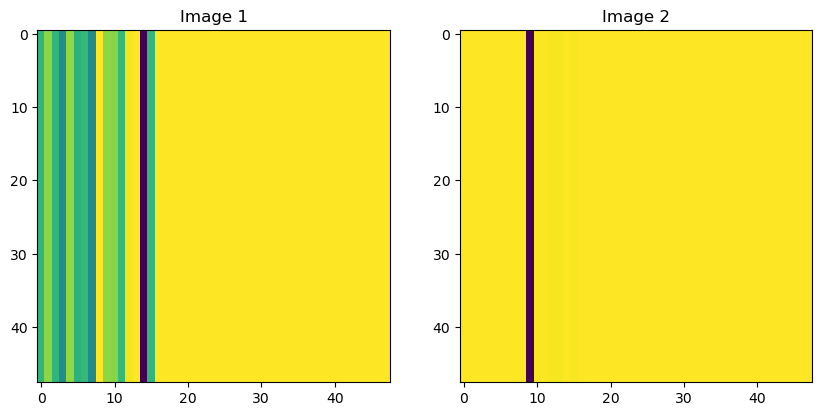

In [ ]:
import matplotlib.pyplot as plt

# Assuming X is your array of image pairs
plt.figure(figsize=(10, 10))

# Display the first image pair
plt.subplot(1, 2, 1)
plt.imshow(X[0, 0, 0])#,cmap='gray')
plt.title('Image 1')

plt.subplot(1, 2, 2)
plt.imshow(X[0, 1, 0])#, cmap='gray')
plt.title('Image 2')

plt.show()


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense

def build_base_network(input_shape):
    seq = Sequential()
    
    nb_filter = [32, 64, 32]
    kernel_size = 3

    # Convolutional layer 1
    seq.add(Conv2D(nb_filter[0], (kernel_size, kernel_size), input_shape=input_shape, padding='valid', data_format='channels_first'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))

    # Convolutional layer 2
    seq.add(Conv2D(nb_filter[1], (kernel_size, kernel_size), padding='valid', data_format='channels_first'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))

    # Convolutional layer 3
    seq.add(Conv2D(nb_filter[2], (kernel_size, kernel_size), padding='valid', data_format='channels_first'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), data_format='channels_first'))

    # Flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dense(50, activation='relu'))
    return seq


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.30)
print('x_train',x_train.shape)
print('x_test',x_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

x_train (84, 2, 3, 48, 48)
x_test (36, 2, 3, 48, 48)
y_train (84, 3)
y_test (36, 3)


In [ ]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)
print('input_dim',input_dim)

base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])


input_dim (3, 48, 48)


In [ ]:
epochs = 40
rms = optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#RMSprop()
rms = RMSprop()

earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1,
                              restore_best_weights=True)
callback_early_stop_reduceLROnPlateau=[earlyStopping]

In [ ]:
model = Model(inputs=[img_a, img_b], outputs=distance)
model.compile(loss=contrastive_loss, optimizer=rms,metrics=[accuracy])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 48, 48)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 3, 48, 48)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 50)           109970      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['sequential[0][0]',         

In [ ]:
from keras.callbacks import EarlyStopping, CSVLogger
from keras.optimizers import Adam, RMSprop
from keras.models import Model
from keras.layers import Input

# Define your inputs
img_1 = x_train[:, 0]
img2 = x_train[:, 1]

# Define your optimizer and callbacks
rms = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, restore_best_weights=True)
csv_logger = CSVLogger('training.log')  # logs epoch results to a csv file
callback_early_stop_reduceLROnPlateau = [earlyStopping, csv_logger]

# Build, compile and train the model
base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])
model = Model(inputs=[img_a, img_b], outputs=distance)
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
history = model.fit([img_1, img2], y_train, validation_split=0.1, batch_size=batch_size, verbose=1, epochs=epochs, shuffle=True, callbacks=callback_early_stop_reduceLROnPlateau)

# Save model weights and architecture
model.save_weights('model_weights.h5')
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())
print('Model saved.')


Epoch 1/40
1/1 [==============================] - 3s 3s/step - loss: 0.4688 - accuracy: 0.4933 - val_loss: 0.2156 - val_accuracy: 0.7778
Epoch 2/40
1/1 [==============================] - 1s 980ms/step - loss: 0.4610 - accuracy: 0.4933 - val_loss: 0.2137 - val_accuracy: 0.7778
Epoch 3/40
1/1 [==============================] - 1s 1s/step - loss: 0.4536 - accuracy: 0.4933 - val_loss: 0.2108 - val_accuracy: 0.7778
Epoch 4/40
1/1 [==============================] - 2s 2s/step - loss: 0.4420 - accuracy: 0.4933 - val_loss: 0.2118 - val_accuracy: 0.7778
Epoch 5/40
1/1 [==============================] - 2s 2s/step - loss: 0.4341 - accuracy: 0.4933 - val_loss: 0.2072 - val_accuracy: 0.7778
Epoch 6/40
1/1 [==============================] - 1s 1s/step - loss: 0.4207 - accuracy: 0.4933 - val_loss: 0.2047 - val_accuracy: 0.7778
Epoch 7/40
1/1 [==============================] - 1s 1s/step - loss: 0.4102 - accuracy: 0.4933 - val_loss: 0.2033 - val_accuracy: 0.7778
Epoch 8/40
1/1 [======================

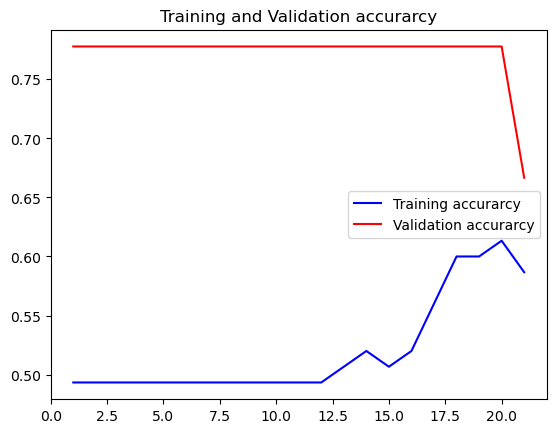

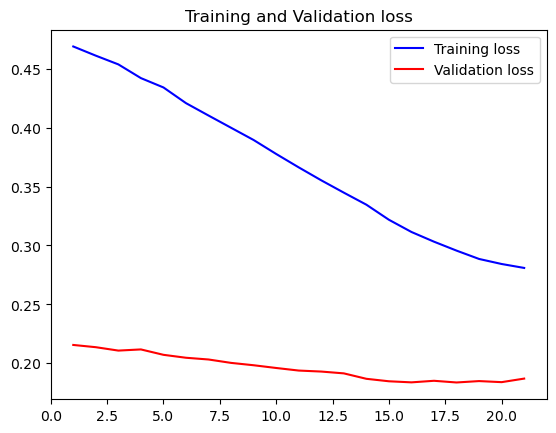

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

For evaluation on test set 

In [90]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score

# Assuming img_1_test, img2_test are your test images and y_test are the true labels
img_1_test = x_test[:,0]
img2_test = x_test[:,1]
y_test = y_test

# Get the model's predictions
y_pred = model.predict([img_1_test, img2_test])

# The predictions are probabilities, so we need to convert them to binary labels
# This threshold might need to be adjusted depending on your problem
y_pred = np.where(y_pred > 0.5, 1, 0)
#y_pred = np.where(y_pred > 0.5, 1, 0).astype('int')

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate Precision
precision = precision_score(y_test, y_pred)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)

# Print the metrics
print("Confusion Matrix:\n", cm)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("F1 Score: ", f1)


2/2 [==============================] - 0s 7ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

To calculate area under the curve AUC